In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# Step 1
## Graph generation, train/test splitting and feature generation

Generate/import graph from avalible `generator` classes

In [4]:
from lib.generators.LFR import LFR
from lib.generators.OLP import OLP


#generator = LFR(n=5000, t1=3, t2=1.1, m=0.1, seed=seed)
generator = OLP(seed=seed)
feature_names = generator.feature_names

Loading file...
File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [23]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [24]:
link_prediction_train['goal'].value_counts()

0    884
1    884
Name: goal, dtype: int64

In [25]:
link_prediction_test['goal'].value_counts()

0    1320
1     184
Name: goal, dtype: int64

In [26]:
classifier_test['goal'].value_counts()

0    1313
1     193
Name: goal, dtype: int64

# Step 2
## Link prediction model

Predict links using one of the avalble link prediction models

In [27]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,1,25,0,0.000000,0.666667,0.000000,0.000287,0.005142,0.000000,0.000000,0.000000,6.661338e-16,3.397295e-15,-5.252839e-16,0.05
1,132,198,0,0.088889,0.000000,0.002561,0.001228,0.266712,0.044944,1.128642,0.117109,-9.992007e-16,8.888889e-02,1.818182e-01,0.00
2,124,189,0,0.066667,0.000000,0.001478,0.002180,0.346932,0.033333,0.821492,0.078431,-1.970646e-15,6.666667e-02,8.571429e-02,0.69
3,69,130,0,0.111111,0.000000,0.003906,0.005778,0.218375,0.054945,1.325735,0.115687,-2.879641e-16,1.111111e-01,6.250000e-02,1.00
4,30,107,0,0.511111,0.000000,0.006970,0.005144,0.564621,0.250000,5.893224,0.487435,9.593021e-16,5.111111e-01,3.833333e-01,0.02


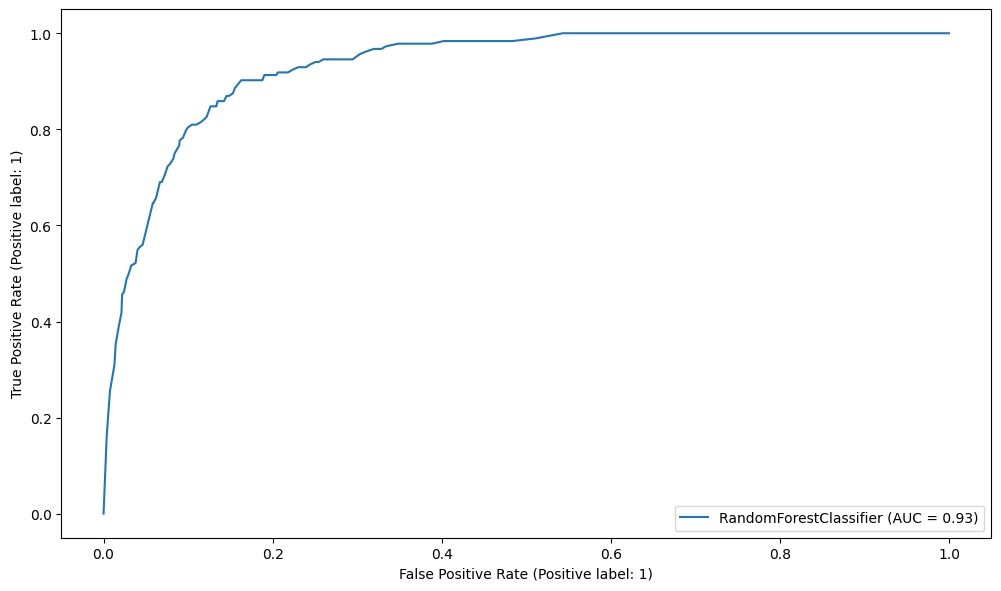

In [28]:
from sklearn import metrics


metrics.plot_roc_curve(model.get_model(), link_prediction_test[feature_names], link_prediction_test['goal'])  

# Step 3
## Quality class analisys

In [29]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,1,25,0,0.000000,0.666667,0.000000,0.000287,0.005142,0.000000,0.000000,0.000000,6.661338e-16,3.397295e-15,-5.252839e-16,0.05,0.05
1,132,198,0,0.088889,0.000000,0.002561,0.001228,0.266712,0.044944,1.128642,0.117109,-9.992007e-16,8.888889e-02,1.818182e-01,0.00,0.00
2,124,189,0,0.066667,0.000000,0.001478,0.002180,0.346932,0.033333,0.821492,0.078431,-1.970646e-15,6.666667e-02,8.571429e-02,0.69,0.69
3,69,130,0,0.111111,0.000000,0.003906,0.005778,0.218375,0.054945,1.325735,0.115687,-2.879641e-16,1.111111e-01,6.250000e-02,1.00,1.00
4,30,107,0,0.511111,0.000000,0.006970,0.005144,0.564621,0.250000,5.893224,0.487435,9.593021e-16,5.111111e-01,3.833333e-01,0.02,0.02


In [30]:
# statistics on error
link_proba['abs_error'].describe()

count    1504.000000
mean        0.457926
std         0.413534
min         0.000000
25%         0.010000
50%         0.395000
75%         0.930000
max         1.000000
Name: abs_error, dtype: float64

In [31]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.395

In [32]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,1,25,0,0.000000,0.666667,0.000000,0.000287,0.005142,0.000000,0.000000,0.000000,6.661338e-16,3.397295e-15,-5.252839e-16,0.05,0.05,1
1,132,198,0,0.088889,0.000000,0.002561,0.001228,0.266712,0.044944,1.128642,0.117109,-9.992007e-16,8.888889e-02,1.818182e-01,0.00,0.00,1
2,124,189,0,0.066667,0.000000,0.001478,0.002180,0.346932,0.033333,0.821492,0.078431,-1.970646e-15,6.666667e-02,8.571429e-02,0.69,0.69,0
3,69,130,0,0.111111,0.000000,0.003906,0.005778,0.218375,0.054945,1.325735,0.115687,-2.879641e-16,1.111111e-01,6.250000e-02,1.00,1.00,0
4,30,107,0,0.511111,0.000000,0.006970,0.005144,0.564621,0.250000,5.893224,0.487435,9.593021e-16,5.111111e-01,3.833333e-01,0.02,0.02,1


In [33]:
link_proba['quality_label'].value_counts()

0    1016
1     752
Name: quality_label, dtype: int64

# Step 4
## Quality class prediction

In [34]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = clf = DecisionTreeClassifier(random_state=seed)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(random_state=756)

In [ ]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [ ]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

In [35]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,89,191,0,0.377778,0.000000,0.007496,0.003051,0.387727,0.207317,4.361750,0.355651,-2.574330e-15,3.777778e-01,4.722222e-01,1.00,0,1.00,0
1,150,204,0,0.088889,0.000000,0.005000,0.001551,0.136099,0.071429,1.111056,0.117947,-6.522560e-16,8.888889e-02,2.000000e-01,0.40,0,0.40,0
2,142,244,0,0.000000,0.333333,0.000000,0.000117,0.036510,0.000000,0.000000,0.000000,-8.326673e-17,3.307351e-15,-7.517135e-16,0.00,1,0.00,1
3,187,213,0,0.022222,0.000000,0.004049,0.003314,0.041310,0.032258,0.328459,0.047619,-4.857226e-16,2.222222e-02,5.263158e-02,0.35,1,0.35,0
4,171,253,0,0.222222,0.000000,0.007407,0.003525,0.230374,0.149254,2.869532,0.318279,-1.318390e-15,2.222222e-01,3.703704e-01,0.81,0,0.81,0


In [36]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     758
0                     748
dtype: int64

In [37]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1058
0                           448
dtype: int64

In [38]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1506.000000
1,Accuracy,0.706507
2,Precision,0.745428
3,Recall,0.706507
4,F1 score,0.693940


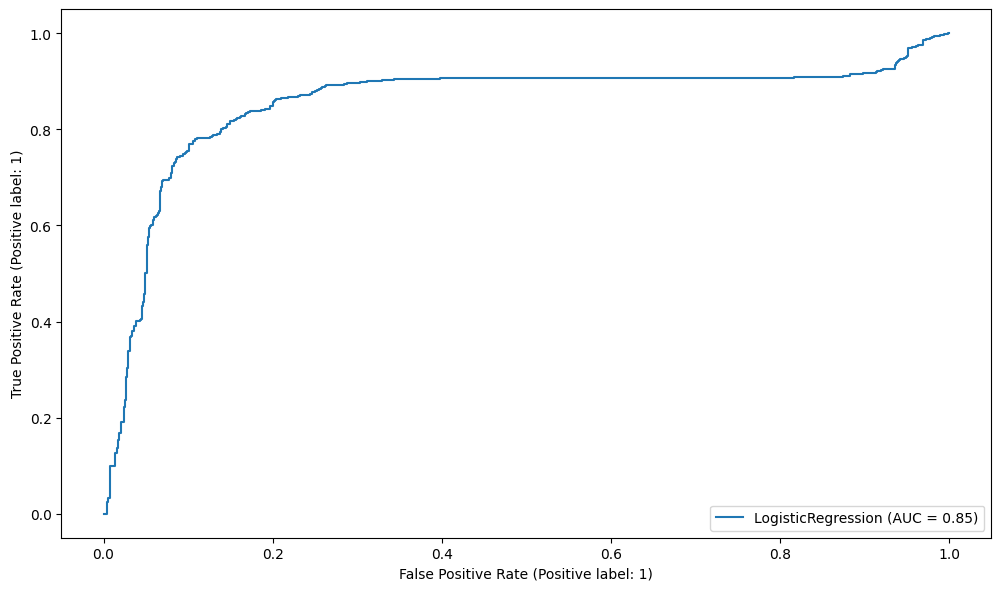

In [39]:
metrics.plot_roc_curve(clf, classifier_test[feature_names], classifier_test['true_quality_label'])  

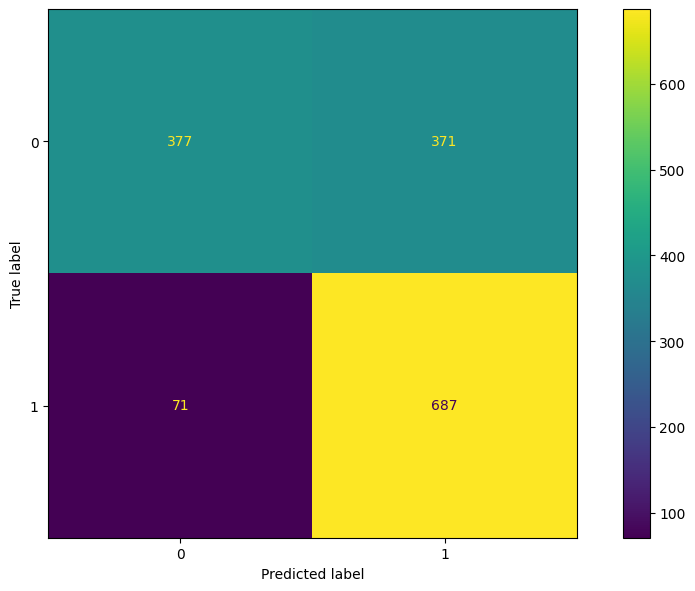

In [40]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])